# Checking if scyan is installed

In [1]:
try:
    import scyan
    print("scyan is installed.")
except ImportError:
    print("scyan is not installed. Installing now...")
    !pip install scyan

Seed set to 0


scyan is installed.


In [2]:
import anndata
import scyan
from pathlib import Path
import pandas as pd
import time
import matplotlib.pyplot as plt

Seed set to 0


# Concaténation de fichier FSC (WT1)

In [2]:
# Chemin du dossier contenant les fichiers FCS
folder_path = Path(r"C:/Users/anush/Desktop/M1 BME/S2/stage/fcs_data/WT-2")

# Lister les chemins des fichiers FCS
fcs_paths = [path for path in folder_path.iterdir() if path.suffix == ".fcs"]

def read_one(path):
    adata_WT2 = scyan.read_fcs(path)
    adata_WT2.obs["file"] = path.stem
    adata_WT2.obs["batch"] = "NA"
    return adata_WT2

adata_WT2 = anndata.concat([read_one(p) for p in fcs_paths], index_unique="-")

# Preprocessing 

In [3]:
# Prétraitement des données
is_cytof = True

if is_cytof:
    scyan.preprocess.asinh_transform(adata_WT2)
else:
    scyan.preprocess.auto_logicle_transform(adata_WT2)

scyan.preprocess.scale(adata_WT2)

[INFO] (scyan.preprocess) Data will be standardised, and translated so that 0 goes to -1. This is advised only when using CyTOF data (if this is not your case, consider running 'auto_logicle_transform' instead of 'asinh_transform').


# Knowledge table

In [4]:
file_path = 'C:/Users/anush/Desktop/M1 BME/S2/stage/Report/Table_ref_V2.csv'
table = pd.read_csv(file_path, index_col=[0, 1])

# Sanity check

In [5]:
# Vérification des marqueurs manquants
missing_markers = [col for col in table.columns if col not in adata_WT2.var_names]
if missing_markers:
    print("Markers in table.columns not present in adata_WT2.var_names:")
    print(missing_markers)
else:
    print("All markers in table.columns are present in adata_WT2.var_names.")

All markers in table.columns are present in adata_WT2.var_names.


# Duplicate checking

In [6]:
# Check for duplicate rows based on the markers expression
duplicates = table[table.duplicated(keep=False)]

if not duplicates.empty:
    print("Duplicate rows found based on marker expressions:")
    print(duplicates)
else:
    print("No duplicates found based on marker expressions.")

No duplicates found based on marker expressions.


# Timepoint function

In [8]:
# Map time points and treatments
def map_time_point(filename):
    parts = filename.split('_')
    if len(parts) >= 2:
        day = parts[1]  # Extract day (e.g., "Day0", "Day7", "Day10")
        return day
    return 'Unknown'

def map_treatment(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        treatment = parts[2]  # Extract treatment if available
        return treatment
    return 'None'

adata_WT2.obs["time_point"] = adata_WT2.obs["file"].map(map_time_point)
adata_WT2.obs["treatment"] = adata_WT2.obs["file"].map(map_treatment)

adata_WT2.obs["time_point"] = pd.Categorical(
    adata_WT2.obs["time_point"],
    categories=["Day0", "Day7", "Day10"],
    ordered=True
)

print("Unique time points (with order):")
print(adata_WT2.obs["time_point"].unique())
print("Unique treatments:")
print(adata_WT2.obs["treatment"].unique())

print(adata_WT2.obs.head(8))

Unique time points (with order):
['Day0', 'Day7']
Categories (3, object): ['Day0' < 'Day7' < 'Day10']
Unique treatments:
['Alive' 'DMSO' 'G10' 'G25' 'G50']
     Time     SSC-H         SSC-A      FSC-H         FSC-A   SSC-B-H  \
0-0   9.0  342496.0  586305.93750   760110.0  1.060118e+06  261539.0   
1-0  32.0  391665.0  571944.12500   911167.0  1.230728e+06  317661.0   
2-0  33.0  306199.0  462572.28125   879154.0  1.245196e+06  231338.0   
3-0  46.0  355758.0  578071.81250  1006003.0  1.646604e+06  270255.0   
4-0  50.0  296230.0  380590.06250   741504.0  8.586988e+05  291449.0   
5-0  56.0  293351.0  406750.62500   839868.0  1.024074e+06  227797.0   
6-0  67.0  409551.0  580984.68750   880670.0  1.129840e+06  330241.0   
7-0  95.0  274523.0  348510.93750   740943.0  8.244442e+05  249370.0   

          SSC-B-A          PU1         CEBPA         GATA2  ...  \
0-0  387001.03125  -141.373657  30525.390625   8627.002930  ...   
1-0  388553.96875  4912.084473  78305.359375  15231.330078  .

# UMAP

In [9]:
# Calculer l'UMAP
start_time = time.time()
scyan.tools.umap(adata_WT2, markers=table.columns)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps écoulé pour le calcul de l'UMAP : {elapsed_time:.2f} secondes")

[INFO] (scyan.tools.representation) Fitting UMAP...


Temps écoulé pour le calcul de l'UMAP : 229.32 secondes


# Saving the Scyan Project

In [10]:
# Sauvegarder le projet
scyan.data.add("WT2", adata_WT2, table)

[INFO] (scyan.data.datasets) Creating new dataset folder at C:\Users\anush\.scyan_data\WT2
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\WT2\default.h5ad
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\WT2\default.csv


# Loading the Scyan project

In [3]:
# Charger les données
adata_WT2, table = scyan.data.load("WT2")

# Model fitting

In [4]:
model_WT2 = scyan.Scyan(adata_WT2, table)
model_WT2.fit()

[INFO] (scyan.model) Initialized Scyan model with N=426758 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5
"warm_up":         (0.35, 4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params | Mode 
-----------------------------------------------
0 | module | ScyanModule | 34.6 K | train
-----------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.139     Total estimated model params size (MB)
243       Modules in train mode
0         M

Training: |                                                                                      | 0/? [00:00<…

[INFO] (scyan.model) Ended warm up epochs
[INFO] (scyan.model) Successfully ended training.


Scyan model with N=426758 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False

# 1st prediction

In [5]:
model_WT2.predict()

DataLoader:   0%|          | 0/53 [00:00<?, ?it/s]

[WARNING] (scyan.model) 22 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


0         Erythrocytes_CD45+
1         Erythrocytes_CD45+
2         Erythrocytes_CD45+
3         Erythrocytes_CD45+
4         Erythrocytes_CD45+
                 ...        
426753    Erythrocytes_CD45+
426754    Erythrocytes_CD45-
426755    Erythrocytes_CD45-
426756    Erythrocytes_CD45+
426757    Erythrocytes_CD45+
Length: 426758, dtype: category
Categories (6, object): [' CD45RA+ Memory Effector T cell', 'Erythrocytes_CD45+', 'Erythrocytes_CD45-', 'LSC_CD34-_CD117+', 'LSC_CD34-_CD117-', 'Transitional & Memory effector T cell']

# Checking the threshold

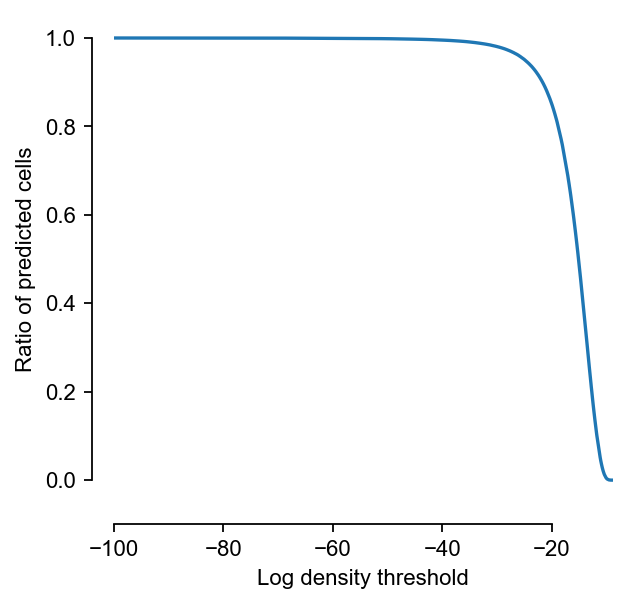

In [6]:
scyan.plot.log_prob_threshold(adata_WT2)

# UMAP visualization

In [7]:
threshold = -30
model_WT2.predict(log_prob_th=threshold)

DataLoader:   0%|          | 0/53 [00:00<?, ?it/s]

[WARNING] (scyan.model) 22 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


0         Erythrocytes_CD45+
1         Erythrocytes_CD45+
2         Erythrocytes_CD45+
3         Erythrocytes_CD45+
4         Erythrocytes_CD45+
                 ...        
426753    Erythrocytes_CD45+
426754    Erythrocytes_CD45-
426755    Erythrocytes_CD45-
426756                   NaN
426757    Erythrocytes_CD45+
Length: 426758, dtype: category
Categories (6, object): [' CD45RA+ Memory Effector T cell', 'Erythrocytes_CD45+', 'Erythrocytes_CD45-', 'LSC_CD34-_CD117+', 'LSC_CD34-_CD117-', 'Transitional & Memory effector T cell']

# Palette

In [10]:
# Define the color palettes for UMAP visualization
# Define the updated unique color palette for UMAP visualization
color_palette = {
    'LSC_CD34+_CD117+': '#D9534F',         # Red
    'LSC_CD34+_CD117-': '#C8102E',         # Dark Red
    'LSC_CD34-_CD117+': '#B02E26',         # Crimson
    'LSC_CD34-_CD117-': '#A7322A',         # Dark Crimson
    'HSC_CD117+': '#1E88E5',               # Blue
    'HSC_CD117-': '#1976D2',               # Dark Blue
    'CD34+CD38+CD123+ HSPCs': '#66BB6A',   # Light Green
    'CMP': '#4CAF50',                      # Green
    'MEP': '#43A047',                      # Dark Green
    'GMP': '#388E3C',                      # Olive Green
    'pDC': '#5C6BC0',                     # Medium Blue
    'NK': '#26A69A',                      # Teal
    'NK-CD62L-': '#004D40',               # Dark Teal
    'B cells': '#FFCA28',                 # Yellow
    'Plasma B': '#FFB300',                # Amber
    'Granulocytes': '#90A4AE',            # Grey
    'Basophils': '#78909C',               # Blue Grey
    'Naive T cells': '#AB47BC',           # Purple
    'CD45RA+ Memory Effector T cell': '#9C27B0', # Dark Purple
    'Central Memory T cell': '#8E24AA',   # Medium Purple
    'Transitional & Memory effector T cell': '#7B1FA2', # Deep Purple
    'Erythrocytes_CD45+': '#E57373',      # Light Coral
    'Erythrocytes_CD45-': '#F44336',      # Red
    'CD11B+_Monocytes': '#BCAAA4',        # Light Brown
    'CD11B+_Monocytes*': '#A1887F',       # Medium Brown
    'Promonocytes': '#D7CCC8',            # Beige
    'Mono_Myeloblastes_CD15+': '#7CB342', # Olive Drab
    'Mono_Myeloblastes_CD15-': '#9CCC65', # Light Olive
}

# Define the updated hierarchical color palette
hierarchy_palette = {
    'LSC': '#D9534F',                    # Red
    'HSC': '#1E88E5',                    # Blue
    'Progenitors': '#66BB6A',            # Light Green
    'Dendritic': '#5C6BC0',              # Medium Blue
    'NK': '#26A69A',                    # Teal
    'B Cells': '#FFCA28',               # Yellow
    'Myeloid': '#90A4AE',               # Grey
    'T Cells': '#AB47BC',               # Purple
    'Erythrocytes': '#E57373',          # Light Coral
    'Monocytes': '#BCAAA4',             # Light Brown
    'NKCD62L-': '#004D40',              # Dark Teal
}

# UMAP level plotting

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


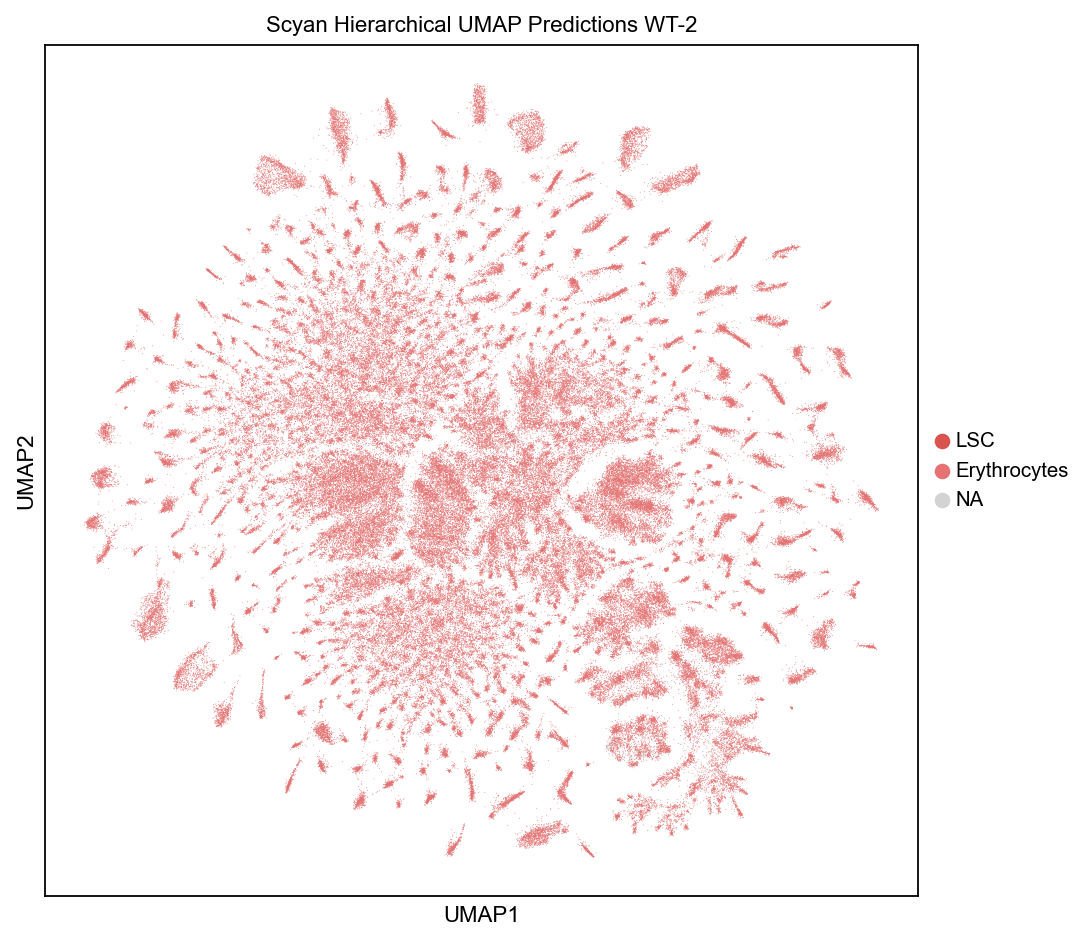

In [11]:
# Tracer le UMAP hiérarchique
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_WT2, color="scyan_pop_level", ax=ax, title="Scyan Hierarchical UMAP Predictions WT-2", palette= hierarchy_palette)
plt.show()

# UMAP plotting (normal)

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


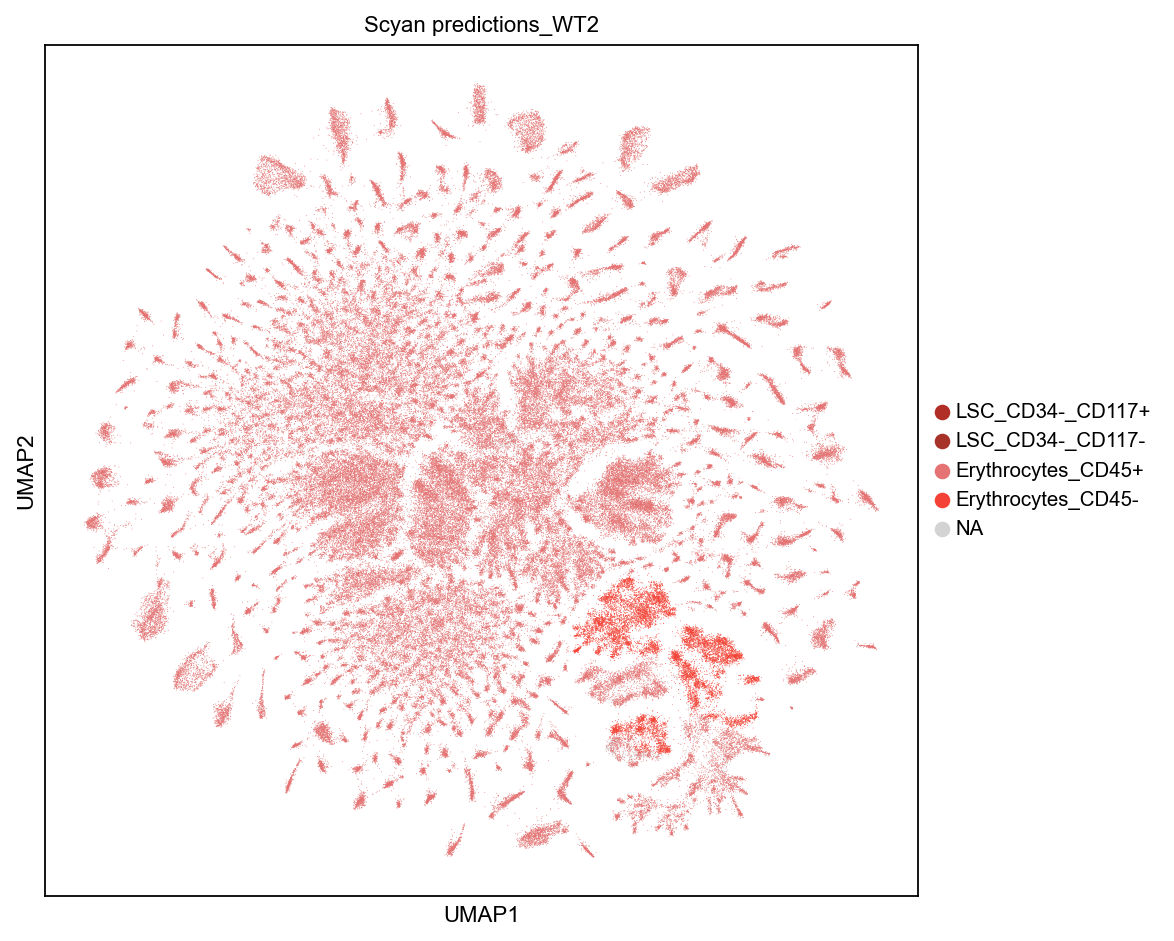

In [12]:
# Sauvegarder les graphiques UMAP
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_WT2, color="scyan_pop", ax=ax, title="Scyan predictions_WT2", palette = color_palette)
plt.show()

# UMAP for each file

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


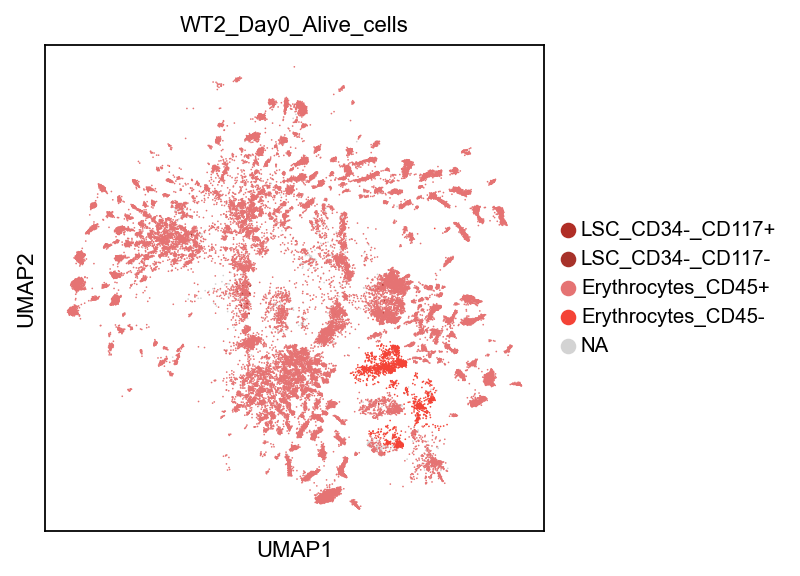

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


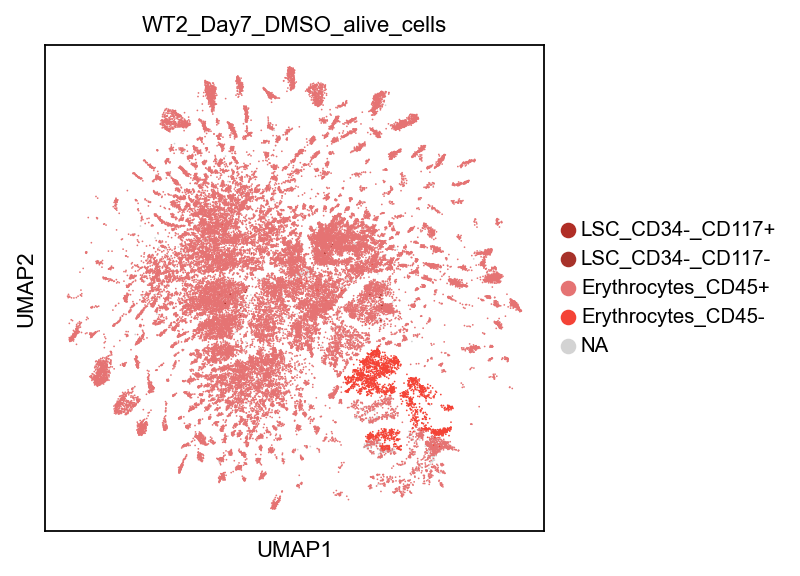

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


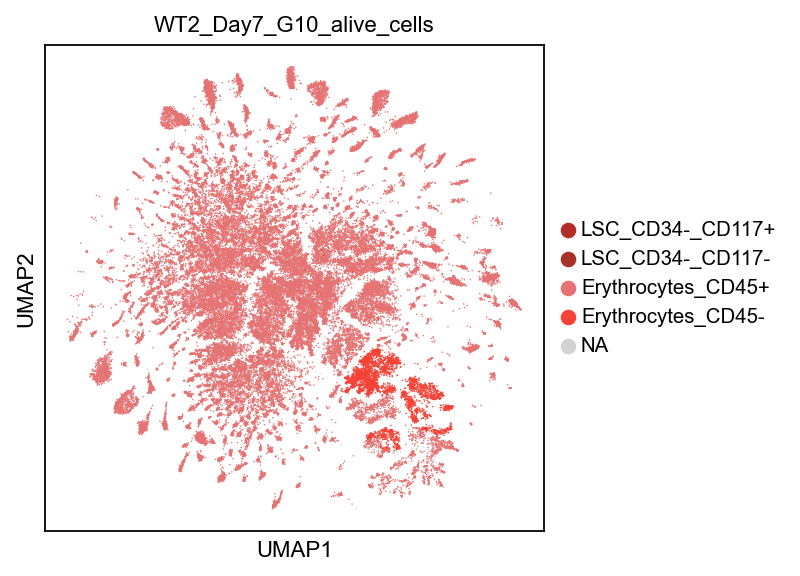

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


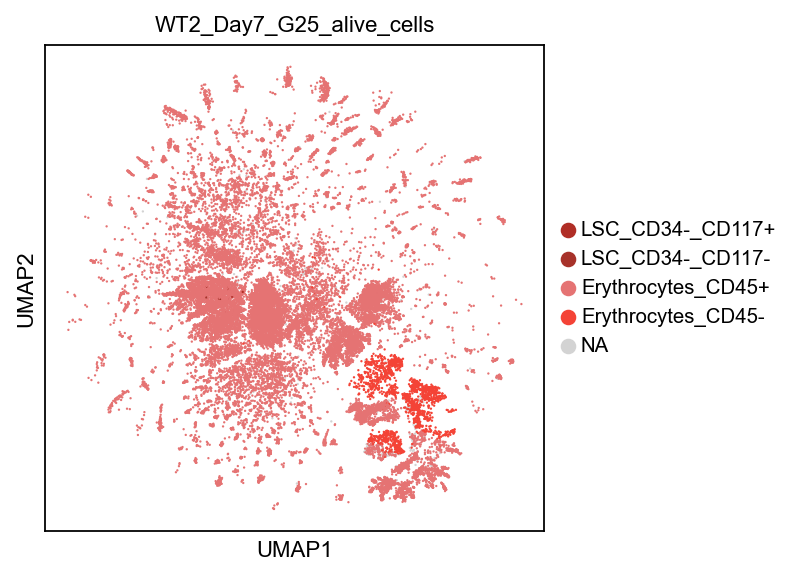

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


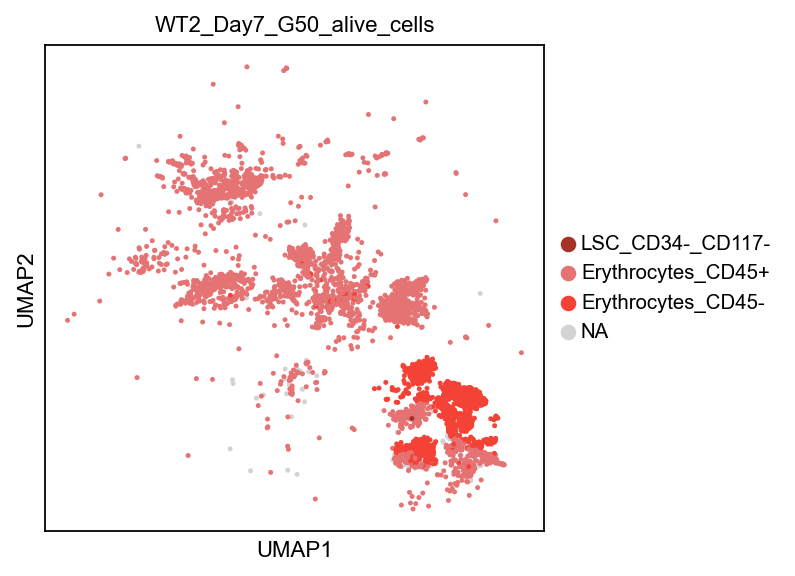

In [13]:
import numpy as np
import scyan

# Loop over each unique file in the 'file' column of the obs DataFrame for adata_WT2
for filename in np.unique(adata_WT2.obs["file"]):
    # Subset the data to include only the cells from the current file
    adata_one_file = adata_WT2[adata_WT2.obs["file"] == filename]
    
    # Plot the UMAP for the current subset of data
    scyan.plot.umap(adata_one_file, color="scyan_pop", title=filename, palette=color_palette)


C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\ratios.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

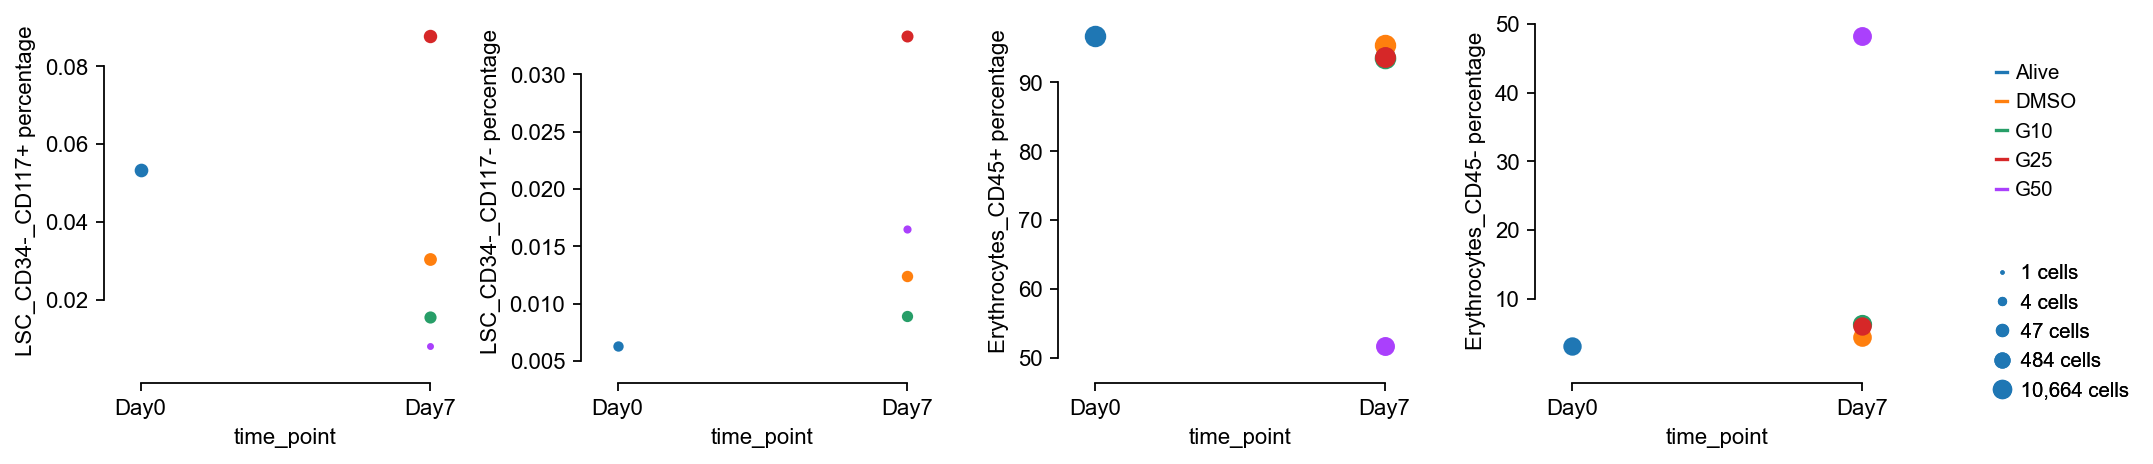

In [14]:
import scyan

# Define the myeloid cell populations of interest
myeloid_populations = [
    'Granulocytes',
    'Basophils',
    'CD11B+_Monocytes',
    'CD11B+_Monocytes*',
    'Promonocytes',
    'Mono_Myeloblastes_CD15+',
    'Mono_Myeloblastes_CD15-',
    'CMP',
    'MEP',
    'GMP',
    'Erythrocytes_CD45+',
    'Erythrocytes_CD45-',
    'LSC_CD34+_CD117+',
    'LSC_CD34+_CD117-',
    'LSC_CD34-_CD117+',
    'LSC_CD34-_CD117-'
]

# Filter the AnnData object to include only the myeloid populations
adata_myeloid = adata_WT2[adata_WT2.obs['scyan_pop'].isin(myeloid_populations)]

# Plot population dynamics for myeloid cells
scyan.plot.pop_dynamics(
    adata_myeloid,        # Use the filtered AnnData object
    time_key="time_point",  # Column name for time points
    groupby="treatment",    # Column name for grouping
    key="scyan_pop"         # Column name for cell populations
)
